In [2]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [4]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

## Step 1: Download images of roses and other flowers

In [5]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [6]:
urls = search_images('rose photos', max_images=1)
urls[0]

Searching for 'rose photos'


'https://www.dawsonsgardenworld.com.au/wp-content/uploads/2016/08/SHIRLEYS-ROSE-scaled.jpg'

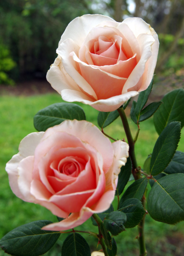

In [7]:
from fastdownload import download_url
dest = 'rose.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'tulip photos'


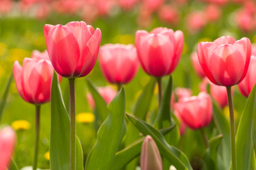

In [8]:
download_url(search_images('tulip photos', max_images=1)[0], 'tulip.jpg', show_progress=False)
Image.open('tulip.jpg').to_thumb(256,256)

In [9]:
searches = 'tulip','rose'
path = Path('rose_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'tulip photo'
Searching for 'tulip sun photo'
Searching for 'tulip shade photo'
Searching for 'rose photo'
Searching for 'rose sun photo'
Searching for 'rose shade photo'


## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [10]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

1

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

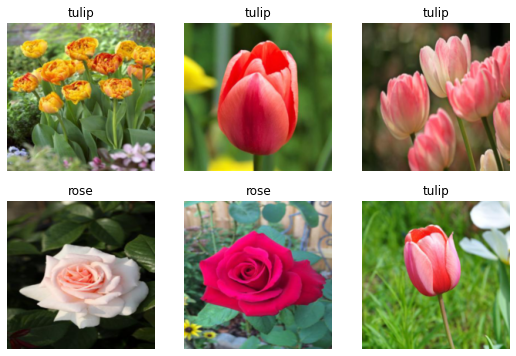

In [11]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [12]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.941886,0.402253,0.171429,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.451543,0.221196,0.057143,00:01
1,0.300646,0.223702,0.057143,00:01
2,0.218026,0.176908,0.028571,00:01


## Step 3: Use our model (and build your own!)

In [14]:
is_rose,_,probs = learn.predict(PILImage.create('rose.jpg'))
print(f"This is a: {is_rose}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: rose.
Probability it's a bird: 0.9562
